# Frequent Mutations
## ESM-FCN_BE
Histogram figure of frequent mutations for ESM-FCN_BE, version G. We'll choose this model because it was the best mean performance between binding and expression.

In [122]:
import pandas as pd

log_dir = "../../src/pnlp/ESM_TL/logs/"

info_df = pd.read_csv("/data/spike_ml/Spike_NLP-Lightning/notebooks/models/scatter/esm_fcn_be/esm_fcn_be.G-predicted_vs_measured.values.csv")
info_df.head(5)

,seq_id,binding_measured_value,binding_predicted_value,expression_measured_value,expression_predicted_value,mode
0,SARS-CoV-2-S19E_E141G_N157A,6.00,5.985470,8.17,8.219058,train
1,SARS-CoV-2-T63F_Y178V_S184L,9.16,9.170079,8.11,8.128667,train
2,SARS-CoV-2-W106A_G146C,6.00,5.997417,7.59,7.673811,train
3,SARS-CoV-2-A18C_R25V_L122T_P149R,6.13,6.163508,8.42,8.468828,train
4,SARS-CoV-2-D59W_P96S,10.16,10.174413,8.02,7.923227,train


### Binding

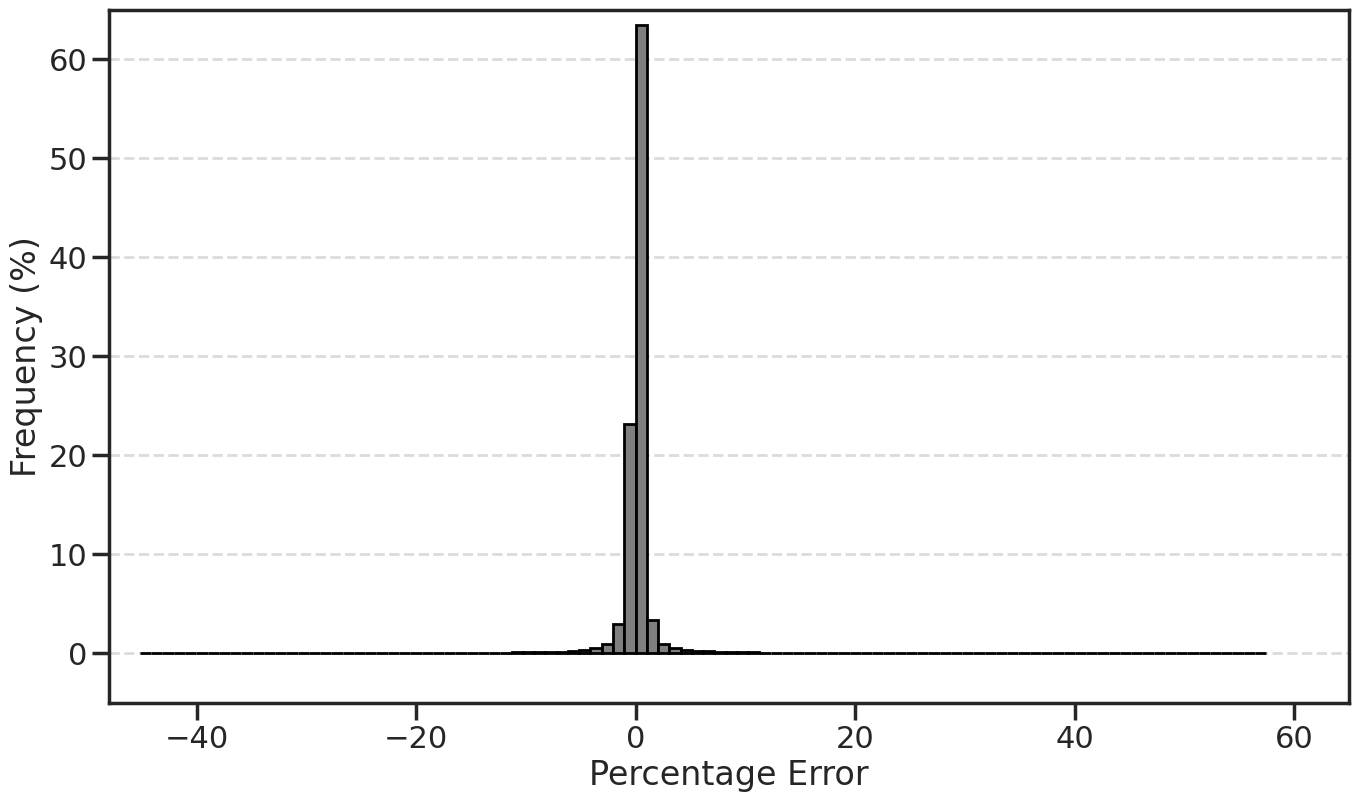

In [123]:
# Binding
binding_df = info_df[["seq_id", "binding_predicted_value", "binding_measured_value", "mode"]].copy()
binding_df["percentage_error"] = ((info_df["binding_predicted_value"] - info_df["binding_measured_value"]) / info_df["binding_measured_value"]) * 100
binding_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    binding_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(binding_df)] * len(binding_df), 
    edgecolor='black', 
    color='tab:grey',
    #linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 65)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_fcn_be.G.binding-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

Now let's pull the outliers from top and bottom 2.5%.

In [124]:
lower_bound = binding_df['percentage_error'].quantile(0.025)
upper_bound = binding_df['percentage_error'].quantile(0.975)

outliers = binding_df[(binding_df['percentage_error'] < lower_bound) | (binding_df['percentage_error'] > upper_bound)].reset_index(drop=True)
outliers.head(5)

,seq_id,binding_predicted_value,binding_measured_value,mode,percentage_error
0,SARS-CoV-2-S53C_N157Y_N171Y_V180S,7.220823,7.46,train,-3.206123
1,SARS-CoV-2-K94Y_E154N_V173C,6.490109,6.80,train,-4.557224
2,SARS-CoV-2-F62S_D137N,8.156197,8.52,train,-4.269998
3,SARS-CoV-2-R27I_A42R_I104K,6.885414,7.15,train,-3.700503
4,SARS-CoV-2-N13F_C49I_A89Y_Y175G,7.555689,7.84,train,-3.626420


We need to adjust the seq_id to acquire the mutations from the data. 

The Spike receptor binding domain (RBD) from SARS-CoV-2 (isolate Wuhan-Hu-1, GenBank : MN908947, residues N331-T531) (checked [Deep Mutational Scanning of SARS-CoV-2 Receptor Binding Domain Reveals Constraints on Folding and ACE2 Binding](https://www.cell.com/cell/fulltext/S0092-8674(20)31003-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420310035%3Fshowall%3Dtrue)). So we need to add 330 to get the RBD site (data not 0 indexed).

In [125]:
df = outliers.copy()
df['target'] = df['seq_id'].str.rsplit('-', n=1).str[0]
df['aa_substitutions'] = df['seq_id'].str.rsplit('-', n=1).str[1].str.rsplit('_')
print(len(df))

df = df.explode('aa_substitutions')
print(len(df))

df['RBD_mutation_site'] = df['aa_substitutions'].str.extract(r'(\d+)').astype(int) + 330 # Extract numeric site, RBD site
df['original_aa'] = df['aa_substitutions'].str[0]
df['new_aa'] = df['aa_substitutions'].str[-1]
df['aa_sub'] = df['original_aa'] + ">" + df['new_aa']
df.head(5)

5138
16902


,seq_id,binding_predicted_value,binding_measured_value,mode,percentage_error,target,aa_substitutions,RBD_mutation_site,original_aa,new_aa,aa_sub
0,SARS-CoV-2-S53C_N157Y_N171Y_V180S,7.220823,7.46,train,-3.206123,SARS-CoV-2,S53C,383,S,C,S>C
0,SARS-CoV-2-S53C_N157Y_N171Y_V180S,7.220823,7.46,train,-3.206123,SARS-CoV-2,N157Y,487,N,Y,N>Y
0,SARS-CoV-2-S53C_N157Y_N171Y_V180S,7.220823,7.46,train,-3.206123,SARS-CoV-2,N171Y,501,N,Y,N>Y
0,SARS-CoV-2-S53C_N157Y_N171Y_V180S,7.220823,7.46,train,-3.206123,SARS-CoV-2,V180S,510,V,S,V>S
1,SARS-CoV-2-K94Y_E154N_V173C,6.490109,6.80,train,-4.557224,SARS-CoV-2,K94Y,424,K,Y,K>Y


Here we will look at the total mutations possible that occur at a particular site across all seq_ids in our outliers. Then we will break it down by amino acid.

In [126]:
from collections import Counter

original_aa_dict = df.groupby('RBD_mutation_site')['original_aa'].apply(lambda x: list(set(x))).to_dict()
new_aa_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(set(x))).to_dict()

new_aa_total_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].count().to_dict()
#print(f"Per site total mutations: {new_aa_total_ct_dict}")

new_aa_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(Counter(x).items())).to_dict()
sorted_new_aa_ct_dict = {k: sorted(v, key=lambda x: x[1], reverse=True) for k, v in new_aa_ct_dict.items()}
#print(f"Per site, per new amino acid substitution total: {sorted_new_aa_ct_dict}")

data = []
for site in sorted(new_aa_total_ct_dict.keys()):
    total = new_aa_total_ct_dict[site]
    mutations = sorted_new_aa_ct_dict[site]
    mutation_str = ', '.join([f"{aa}({count})" for aa, count in mutations])
    data.append({
        'RBD Site': site,
        'Original Amino Acid': original_aa_dict[site][0],
        'Total Possible Mutations': total,
        'Amino Acid Substitutions (Count)': mutation_str
    })

possible_mutations_per_site = pd.DataFrame(data)
#print(possible_mutations_per_site.to_string(index=False))

# Sort and display the top 10
possible_mutations_per_site['Total Possible Mutations'] = pd.to_numeric(possible_mutations_per_site['Total Possible Mutations'])
top_10_highest = possible_mutations_per_site.sort_values('Total Possible Mutations', ascending=False).head(10)
print(top_10_highest.to_string(index=False))

 RBD Site Original Amino Acid  Total Possible Mutations                                                                                             Amino Acid Substitutions (Count)
      420                   D                       230 Y(26), S(25), R(24), L(15), F(15), N(15), I(14), H(12), V(12), T(12), G(11), M(11), K(8), A(7), Q(7), E(6), W(6), C(3), P(1)
      531                   T                       226 R(27), K(22), L(21), S(20), M(16), W(13), V(13), A(12), P(12), N(10), E(10), I(10), C(7), Q(7), G(6), F(6), Y(5), H(5), D(4)
      437                   N                       211    S(22), P(20), T(20), L(19), R(15), I(14), V(12), G(11), D(11), H(9), F(8), K(8), Q(7), W(7), A(7), M(7), Y(6), E(4), C(4)
      391                   C                       211 L(17), T(17), V(17), S(16), R(15), A(13), K(13), M(13), N(12), G(11), P(11), F(11), E(9), I(9), D(7), Y(7), H(6), W(5), Q(2)
      436                   W                       191       R(27), V(20), T(19), L(18), S(16)

Now, we will find the highest score predicted score per site. We save the measured value, and we can use this as a coordinate value associated with it's percentage error.

In [127]:
# Group by 'RBD_mutation_site' and extract all binding_predicted_value scores for each site
all_scores_dict = df.groupby('RBD_mutation_site').apply(
    lambda x: x[['new_aa', 'binding_measured_value', 'binding_predicted_value', 'percentage_error']].values.tolist()
).to_dict()

# Find the highest binding_predicted_value score for each site
highest_scores = {site: max(scores, key=lambda x: x[2])[2] if scores else 0 for site, scores in all_scores_dict.items()}

data = []
for site, max_score in highest_scores.items():
    total = new_aa_total_ct_dict[site]
    scores = all_scores_dict.get(site, [])
    aa_str = ', '.join([f'{aa}' for aa, m_score, p_score, perc_error in scores])
    scores_str = ', '.join([f'{perc_error:.2f}' for aa, m_score, p_score, perc_error in scores])
    data.append({
        'RBD Site': site,
        'Total Mutations': total,
        'Original Amino Acid': original_aa_dict[site][0],
        'Highest Predicted Binding Value': f'{max_score:.2f}',
        'Amino Acid Substitutions': aa_str,
        'Perc Error': scores_str
    })

b_all_scores_per_site = pd.DataFrame(data)
#print(all_scores_per_site.to_string(index=False))

# Sort and display the top 10
b_all_scores_per_site['Highest Predicted Binding Value'] = pd.to_numeric(b_all_scores_per_site['Highest Predicted Binding Value'])
b_top_10_highest = b_all_scores_per_site.sort_values('Highest Predicted Binding Value', ascending=False).head(10)
print(b_top_10_highest.to_string(index=False))

sorted([[s, aa] for s, aa in zip(b_top_10_highest['RBD Site'].to_list(), b_top_10_highest['Original Amino Acid'].to_list())])

 RBD Site  Total Mutations Original Amino Acid  Highest Predicted Binding Value                                                                                                                                                                                                                                                                                                                                                                                                                                               Amino Acid Substitutions                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

/tmp/ipykernel_1159506/2937275485.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_scores_dict = df.groupby('RBD_mutation_site').apply(


[[333, 'T'],
 [335, 'L'],
 [366, 'S'],
 [384, 'P'],
 [394, 'N'],
 [439, 'N'],
 [452, 'L'],
 [462, 'K'],
 [490, 'F'],
 [520, 'A']]

Use the original aa at that position. The error bar here is the percent of mutations that leads to increased (+) or decreased (-) binding (or mutation in a separate figure) with any of the mutations this position was invoved.
- First column is position, second one is AA, third column is impact.
- impact > 0 means "increase." that is a ratio. so 0.5 means 50% increase
- 1.0 means doubled.
- impact <0 means "decrease". -0.5 means half.

In [128]:
import pandas as pd
import numpy as np

def calculate_impact(data):
    data = data.copy()

    # Convert percent error strings to floats
    data['Perc Error'] = data['Perc Error'].str.split(', ').apply(lambda x: [float(i) for i in x])
    
    # Calculate impact
    def impact(errors):
        total = len(errors)
        increased = sum(1 for e in errors if e > 0)
        decreased = sum(1 for e in errors if e < 0)
        return {
            'increased': (increased / total) * 100,
            'decreased': (decreased / total) * 100,
            'neutral': ((total - increased - decreased) / total) * 100,
            'impact': (increased - decreased) / total
        }
    
    results = data.apply(lambda row: impact(row['Perc Error']), axis=1)
    
    impact_df = pd.DataFrame(results.tolist(), index=data.index)
    
    # Add RBD Site and Original Amino Acid columns
    impact_df['RBD Site'] = data['RBD Site']
    impact_df['Original Amino Acid'] = data['Original Amino Acid']
    columns_order = ['RBD Site', 'Original Amino Acid', 'increased', 'decreased', 'neutral', 'impact']
    impact_df = impact_df[columns_order]

    impact_df = impact_df.sort_values('RBD Site')
    
    return impact_df

b_impact_results = calculate_impact(b_all_scores_per_site)
print(b_impact_results.head(5))

   RBD Site Original Amino Acid  increased  decreased  neutral    impact
0       331                   N  50.000000  50.000000      0.0  0.000000
1       332                   I  41.428571  58.571429      0.0 -0.171429
2       333                   T  48.818898  51.181102      0.0 -0.023622
3       334                   N  60.416667  39.583333      0.0  0.208333
4       335                   L  49.342105  50.657895      0.0 -0.013158


Theses are residues from the 6MOJ paper that indicates that the RBD-ACE2 complex forming interface #1 is the biological complex. 

In [129]:
interface_residues = [403, 417,	445, 446, 449, 453, 455, 456, 473, 475, 476, 477, 484, 485, 486, 487, 489, 490, 493, 496, 498, 500, 501, 502, 503, 505]

TOP INCREASING IMPACT Binding:
     RBD Site Original Amino Acid  increased  decreased  neutral    impact
197       334                   N  60.416667  39.583333      0.0  0.208333
176       355                   R  60.317460  39.682540      0.0  0.206349
129       402                   I  62.068966  37.931034      0.0  0.241379
126       405                   D  62.962963  37.037037      0.0  0.259259
123       408                   R  60.465116  39.534884      0.0  0.209302
93        438                   S  60.000000  40.000000      0.0  0.200000
88        443                   S  61.946903  38.053097      0.0  0.238938
83        448                   N  63.333333  36.666667      0.0  0.266667
69        462                   K  65.000000  35.000000      0.0  0.300000
68        463                   P  63.157895  36.842105      0.0  0.263158
56        475                   A  63.013699  36.986301      0.0  0.260274
37        494                   S  63.636364  36.363636      0.0  0.2

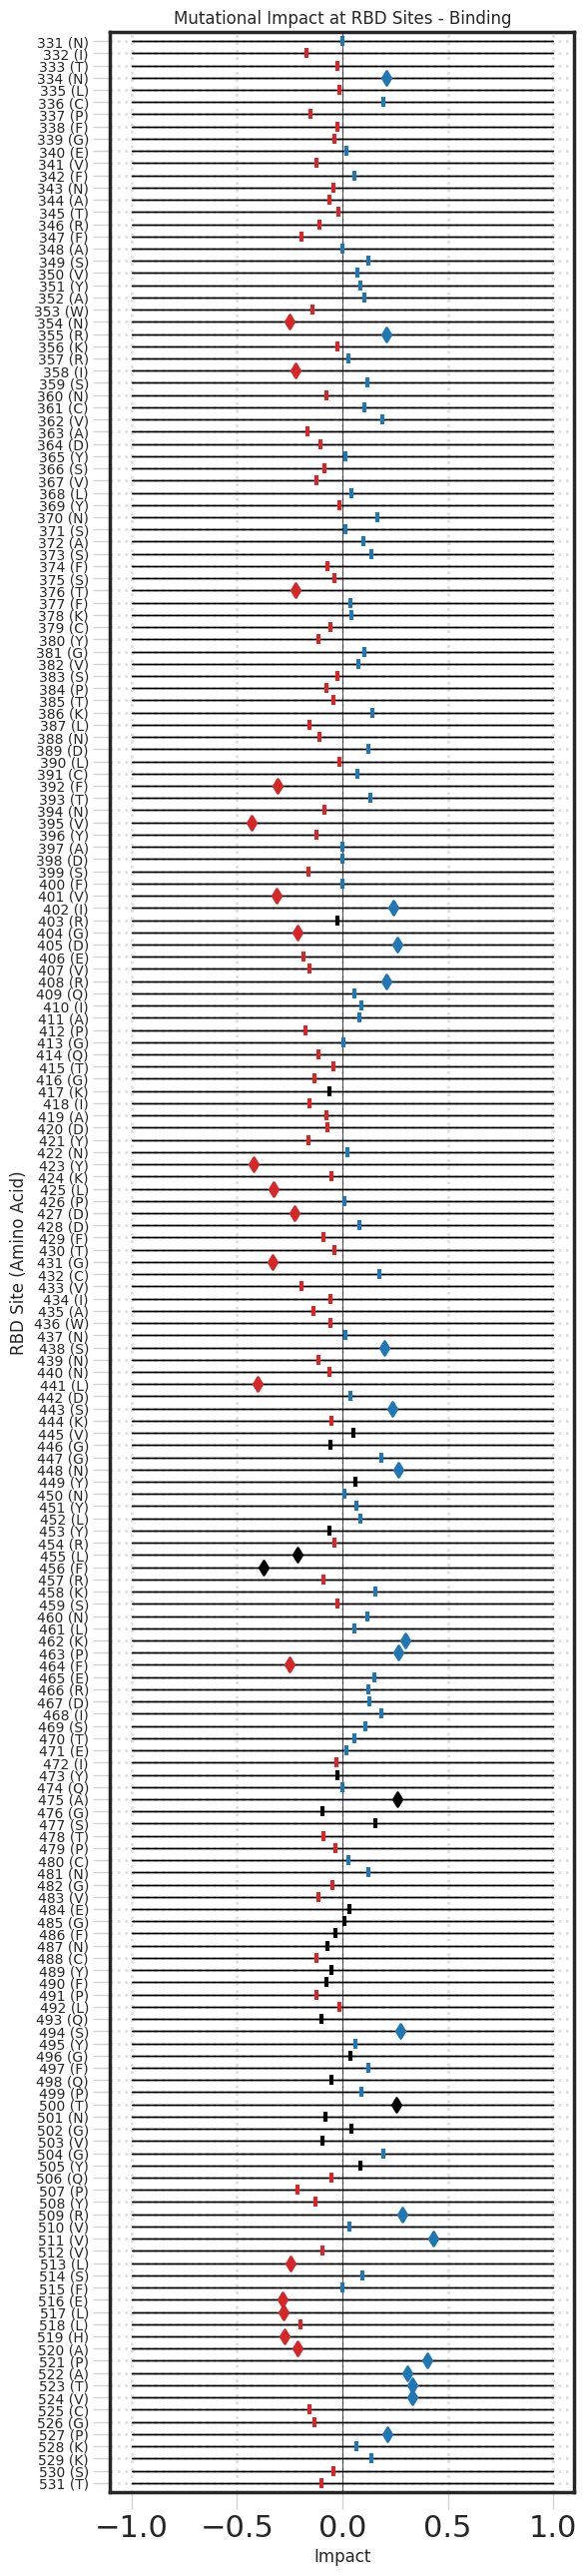

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_mutational_impact(impact_results_df, BorE, interface_residues):
    df = impact_results_df.sort_values('RBD Site', ascending=False).reset_index(drop=True).copy()

    # Find the top n increasing impact
    top_10_indices = df['impact'].nlargest(20).index.sort_values(ascending=False)    
    print(f"TOP INCREASING IMPACT {BorE}:\n{df.loc[top_10_indices].to_string()}\n")
    #print(df.loc[top_10_indices, 'RBD Site'].to_list())

    # Find the top n decreasing impact
    bottom_10_indices = df['impact'].nsmallest(20).index.sort_values(ascending=False)    
    print(f"TOP DECREASING IMPACT {BorE}:\n{df.loc[bottom_10_indices].to_string()}")

    plt.figure(figsize=(6, 32))

    # Track y-tick positions and labels
    yticks = []
    ytick_labels = []

    # Plot one line per RBD site
    for i, row in df.iterrows():
        rbd_site = row['RBD Site'] 
        aa = row['Original Amino Acid']                          
        impact = row['impact']

        # Background horizontal reference line
        plt.plot([-1, 1], [i, i], color='black', linewidth=1, zorder=1)

        # Color depending on impact
        line_color = 'tab:red' if impact < 0 else 'tab:blue'

        # Marker 
        if row.name in top_10_indices:
            marker = 'd'  # Shape for top 10
        elif row.name in bottom_10_indices:
            marker = 'd'  # Shape for bottom 10
        else:
            marker = '|'  # Vertical line for others

        # Background line
        plt.plot([-1, 1], [i, i], color='black', linewidth=1, zorder=1)

        # Plot marker
        if marker is not None:
            plt.scatter(
                impact,
                i,
                color='black' if rbd_site in interface_residues else line_color,
                marker=marker,
                s=50,
                zorder=3
            )

        yticks.append(i)
        ytick_labels.append(f"{rbd_site} ({aa})")

    # Axes and title
    plt.title(f'Mutational Impact at RBD Sites - {BorE}', fontsize=12)
    plt.xlabel('Impact', fontsize=12)
    plt.ylabel('RBD Site (Amino Acid)', fontsize=12)

    # Set axis ticks
    plt.yticks(yticks, ytick_labels)
    plt.tick_params(axis='y', which='major', labelsize=10)
    plt.ylim(-0.75, len(yticks) - 0.25)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    plt.tick_params(
        axis='both',
        direction='out',
        width=1,
        left=True,
        right=False,
        bottom=True,
        top=False,
        color='lightgrey'
    )

    plt.grid(True, linestyle=':', color='lightgrey', alpha=0.7)

    # Save plot
    save_as = f"mutation/mutational_impact.G.{BorE.lower()}"
    plt.savefig(f"{save_as}.pdf", format='pdf', bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format='png', bbox_inches='tight')

plot_mutational_impact(b_impact_results, "Binding", interface_residues)

### Expression

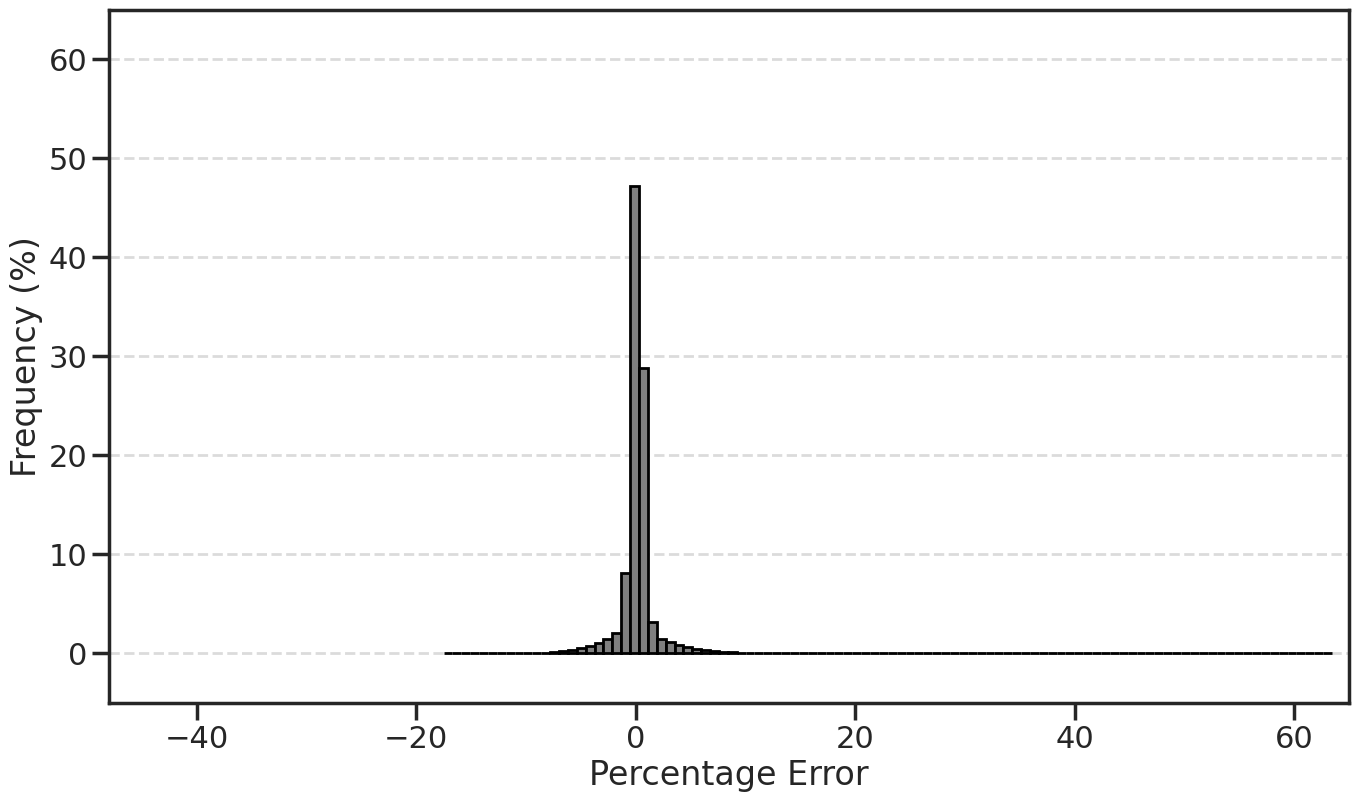

In [139]:
# Expression
expression_df = info_df[["seq_id", "expression_predicted_value", "expression_measured_value", "mode"]].copy()
expression_df["percentage_error"] = ((info_df["expression_predicted_value"] - info_df["expression_measured_value"]) / info_df["expression_measured_value"]) * 100
expression_df.head(5)

# Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')
plt.subplots(figsize=(16, 9)) 

plt.hist(
    expression_df["percentage_error"], 
    bins=100, 
    weights=[100 / len(expression_df)] * len(expression_df), 
    edgecolor='black', 
    color='tab:grey',
    # linewidth=1
)

plt.xlim(-48, 65)  
plt.xlabel("Percentage Error")
plt.ylim(-5, 65)
plt.ylabel("Frequency (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

save_path = "bar/esm_fcn_be.G.expression-percent_error"
plt.savefig(f"{save_path}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches='tight')

Now let's pull the outliers from top and bottom 2.5%.

In [132]:
lower_bound = expression_df['percentage_error'].quantile(0.025)
upper_bound = expression_df['percentage_error'].quantile(0.975)

outliers = expression_df[(expression_df['percentage_error'] < lower_bound) | (expression_df['percentage_error'] > upper_bound)].reset_index(drop=True)
outliers.head(5)

,seq_id,expression_predicted_value,expression_measured_value,mode,percentage_error
0,SARS-CoV-2-T100R_P161L,6.765524,6.280,train,7.731276
1,SARS-CoV-2-N64F_S113A,7.031590,7.300,train,-3.676852
2,SARS-CoV-2-L188N,7.865952,8.165,train,-3.662559
3,SARS-CoV-2-P7H_D90M,5.721656,5.940,train,-3.675820
4,SARS-CoV-2-V52P,7.774480,7.295,train,6.572718


We need to adjust the seq_id to acquire the mutations from the data. 

The Spike receptor binding domain (RBD) from SARS-CoV-2 (isolate Wuhan-Hu-1, GenBank : MN908947, residues N331-T531) (checked [Deep Mutational Scanning of SARS-CoV-2 Receptor Binding Domain Reveals Constraints on Folding and ACE2 Binding](https://www.cell.com/cell/fulltext/S0092-8674(20)31003-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420310035%3Fshowall%3Dtrue)). So we need to add 330 to get the RBD site (data not 0 indexed).

In [133]:
df = outliers.copy()
df['target'] = df['seq_id'].str.rsplit('-', n=1).str[0]
df['aa_substitutions'] = df['seq_id'].str.rsplit('-', n=1).str[1].str.rsplit('_')
print(len(df))

df = df.explode('aa_substitutions')
print(len(df))

df['RBD_mutation_site'] = df['aa_substitutions'].str.extract(r'(\d+)').astype(int) + 330 # Extract numeric site, RBD site
df['original_aa'] = df['aa_substitutions'].str[0]
df['new_aa'] = df['aa_substitutions'].str[-1]
df['aa_sub'] = df['original_aa'] + ">" + df['new_aa']
df.head(5)

5138
17277


,seq_id,expression_predicted_value,expression_measured_value,mode,percentage_error,target,aa_substitutions,RBD_mutation_site,original_aa,new_aa,aa_sub
0,SARS-CoV-2-T100R_P161L,6.765524,6.280,train,7.731276,SARS-CoV-2,T100R,430,T,R,T>R
0,SARS-CoV-2-T100R_P161L,6.765524,6.280,train,7.731276,SARS-CoV-2,P161L,491,P,L,P>L
1,SARS-CoV-2-N64F_S113A,7.031590,7.300,train,-3.676852,SARS-CoV-2,N64F,394,N,F,N>F
1,SARS-CoV-2-N64F_S113A,7.031590,7.300,train,-3.676852,SARS-CoV-2,S113A,443,S,A,S>A
2,SARS-CoV-2-L188N,7.865952,8.165,train,-3.662559,SARS-CoV-2,L188N,518,L,N,L>N


Here we will look at the total mutations possible that occur at a particular site across all seq_ids in our outliers. Then we will break it down by amino acid.

In [134]:
from collections import Counter

original_aa_dict = df.groupby('RBD_mutation_site')['original_aa'].apply(lambda x: list(set(x))).to_dict()
new_aa_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(set(x))).to_dict()

new_aa_total_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].count().to_dict()
#print(f"Per site total mutations: {new_aa_total_ct_dict}")

new_aa_ct_dict = df.groupby('RBD_mutation_site')['new_aa'].apply(lambda x: list(Counter(x).items())).to_dict()
sorted_new_aa_ct_dict = {k: sorted(v, key=lambda x: x[1], reverse=True) for k, v in new_aa_ct_dict.items()}
#print(f"Per site, per new amino acid substitution total: {sorted_new_aa_ct_dict}")

data = []
for site in sorted(new_aa_total_ct_dict.keys()):
    total = new_aa_total_ct_dict[site]
    mutations = sorted_new_aa_ct_dict[site]
    mutation_str = ', '.join([f"{aa}({count})" for aa, count in mutations])
    data.append({
        'RBD Site': site,
        'Original Amino Acid': original_aa_dict[site][0],
        'Total Possible Mutations': total,
        'Amino Acid Substitutions (Count)': mutation_str
    })

possible_mutations_per_site = pd.DataFrame(data)
#print(possible_mutations_per_site.to_string(index=False))

# Sort and display the top 10
possible_mutations_per_site['Total Possible Mutations'] = pd.to_numeric(possible_mutations_per_site['Total Possible Mutations'])
top_10_highest = possible_mutations_per_site.sort_values('Total Possible Mutations', ascending=False).head(10)
print(top_10_highest.to_string(index=False))

 RBD Site Original Amino Acid  Total Possible Mutations                                                                                                Amino Acid Substitutions (Count)
      531                   T                       260   L(27), V(24), K(20), R(20), S(20), M(17), N(15), I(15), P(14), Y(13), W(11), C(10), G(10), A(9), D(9), E(8), Q(8), F(6), H(4)
      420                   D                       247 S(30), Y(20), L(20), R(17), H(17), I(15), N(15), K(14), E(13), G(13), T(12), M(11), A(10), F(10), V(10), C(8), P(5), Q(4), W(3)
      391                   C                       212      L(23), S(20), R(16), V(15), K(15), G(14), P(11), Y(11), A(10), N(10), H(9), M(9), F(8), T(8), D(8), I(7), Q(7), W(6), E(5)
      449                   Y                       201      S(20), R(18), V(18), L(18), T(17), P(14), F(13), C(11), N(10), A(10), K(9), I(8), G(7), Q(6), M(6), W(5), D(5), H(4), E(2)
      371                   S                       200     L(23), R(18), T(18),

Now, we will find the highest score predicted score per site. We save the measured value, and we can use this as a coordinate value associated with it's percentage error.

In [135]:
# Group by 'RBD_mutation_site' and extract all expression_predicted_value scores for each site
all_scores_dict = df.groupby('RBD_mutation_site').apply(
    lambda x: x[['new_aa', 'expression_measured_value', 'expression_predicted_value', 'percentage_error']].values.tolist()
).to_dict()

# Find the highest expression_predicted_value score for each site
highest_scores = {site: max(scores, key=lambda x: x[2])[2] if scores else 0 for site, scores in all_scores_dict.items()}

data = []
for site, max_score in highest_scores.items():
    total = new_aa_total_ct_dict[site]
    scores = all_scores_dict.get(site, [])
    aa_str = ', '.join([f'{aa}' for aa, m_score, p_score, perc_error in scores])
    scores_str = ', '.join([f'{perc_error:.2f}' for aa, m_score, p_score, perc_error in scores])
    data.append({
        'RBD Site': site,
        'Total Mutations': total,
        'Original Amino Acid': original_aa_dict[site][0],
        'Highest Predicted Expression Value': f'{max_score:.2f}',
        'Amino Acid Substitutions': aa_str,
        'Perc Error': scores_str
    })

e_all_scores_per_site = pd.DataFrame(data)
#print(all_scores_per_site.to_string(index=False))

# Sort and display the top 10
e_all_scores_per_site['Highest Predicted Expression Value'] = pd.to_numeric(e_all_scores_per_site['Highest Predicted Expression Value'])
e_top_10_highest = e_all_scores_per_site.sort_values('Highest Predicted Expression Value', ascending=False).head(10)
print(e_top_10_highest.to_string(index=False))

sorted([[s, aa] for s, aa in zip(e_top_10_highest['RBD Site'].to_list(), e_top_10_highest['Original Amino Acid'].to_list())])

 RBD Site  Total Mutations Original Amino Acid  Highest Predicted Expression Value                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Amino Acid Substitutions                                                                                                                                           

/tmp/ipykernel_1159506/3411150519.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_scores_dict = df.groupby('RBD_mutation_site').apply(


[[358, 'I'],
 [362, 'V'],
 [367, 'V'],
 [386, 'K'],
 [417, 'K'],
 [455, 'L'],
 [468, 'I'],
 [486, 'F'],
 [493, 'Q'],
 [531, 'T']]

Use the original aa at that position. The error bar here is the percent of mutations that leads to increased (+) or decreased (-) binding (or mutation in a separate figure) with any of the mutations this position was invoved.
- First column is position, second one is AA, third column is impact.
- impact > 0 means "increase." that is a ratio. so 0.5 means 50% increase
- 1.0 means doubled.
- impact <0 means "decrease". -0.5 means half.

In [136]:
e_impact_results = calculate_impact(e_all_scores_per_site)
print(e_impact_results.head(5))

   RBD Site Original Amino Acid  increased  decreased  neutral    impact
0       331                   N  57.608696  42.391304      0.0  0.152174
1       332                   I  53.125000  46.875000      0.0  0.062500
2       333                   T  59.482759  40.517241      0.0  0.189655
3       334                   N  56.435644  43.564356      0.0  0.128713
4       335                   L  55.670103  44.329897      0.0  0.113402


TOP INCREASING IMPACT Expression:
     RBD Site Original Amino Acid  increased  decreased  neutral    impact
198       333                   T  59.482759  40.517241      0.0  0.189655
180       351                   Y  60.465116  39.534884      0.0  0.209302
156       375                   S  60.169492  39.830508      0.0  0.203390
154       377                   F  70.312500  29.687500      0.0  0.406250
125       406                   E  60.000000  40.000000      0.0  0.200000
123       408                   R  59.375000  40.625000      0.0  0.187500
119       412                   P  60.493827  39.506173      0.0  0.209877
97        434                   I  65.116279  34.883721      0.0  0.302326
92        439                   N  66.666667  33.333333      0.0  0.333333
77        454                   R  61.016949  38.983051      0.0  0.220339
74        457                   R  66.265060  33.734940      0.0  0.325301
71        460                   N  61.702128  38.297872      0.0  

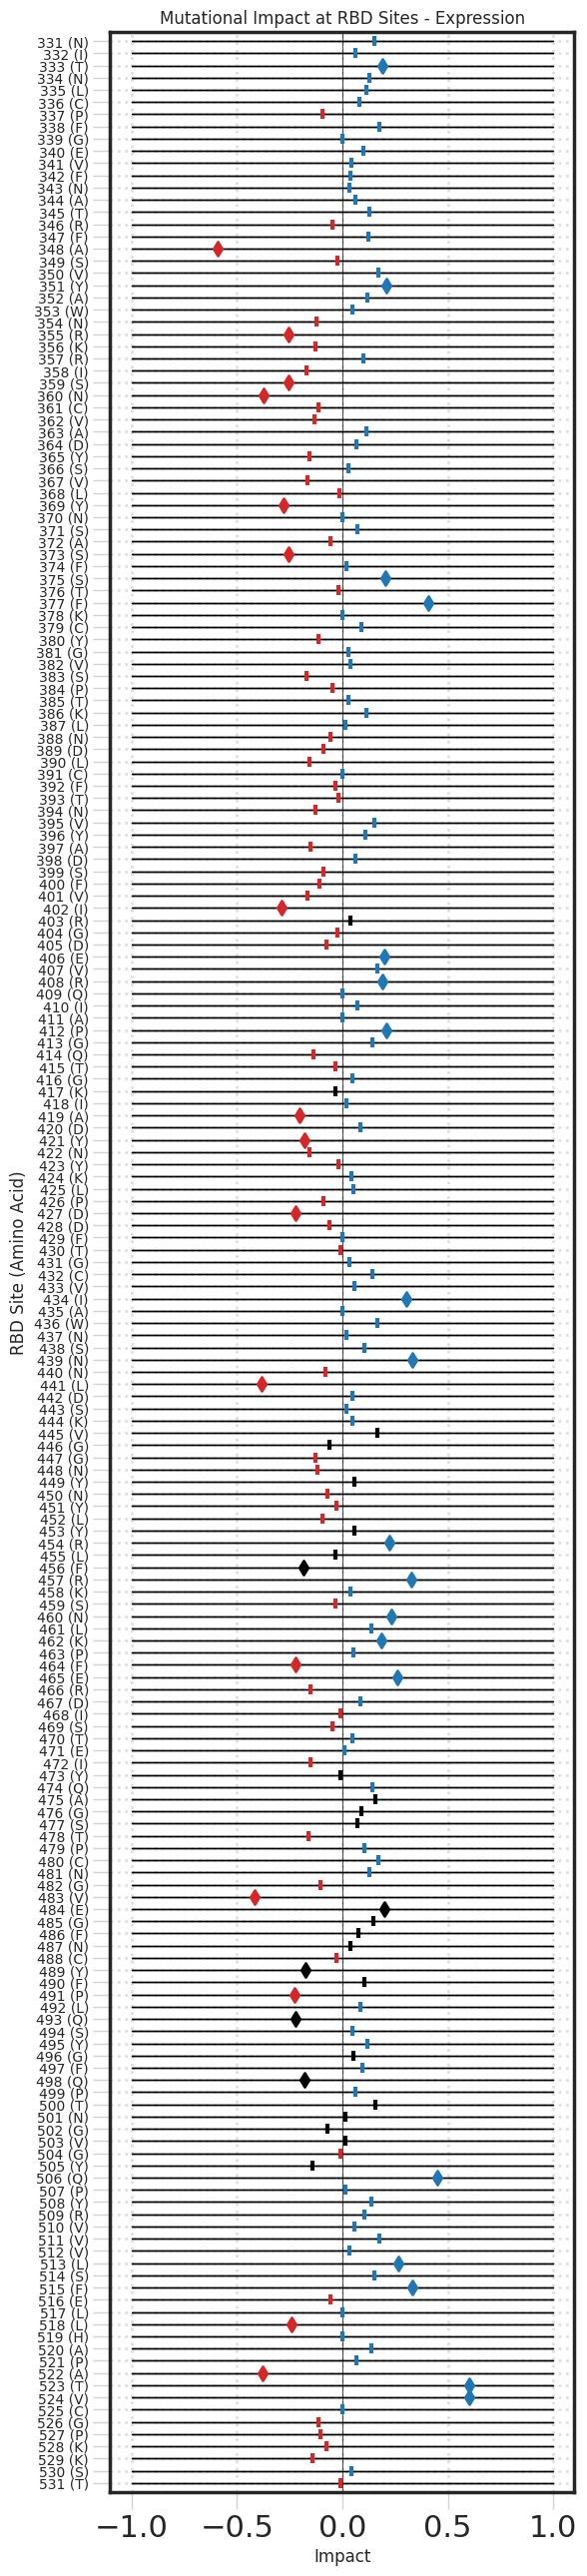

In [137]:
plot_mutational_impact(e_impact_results, "Expression", interface_residues)

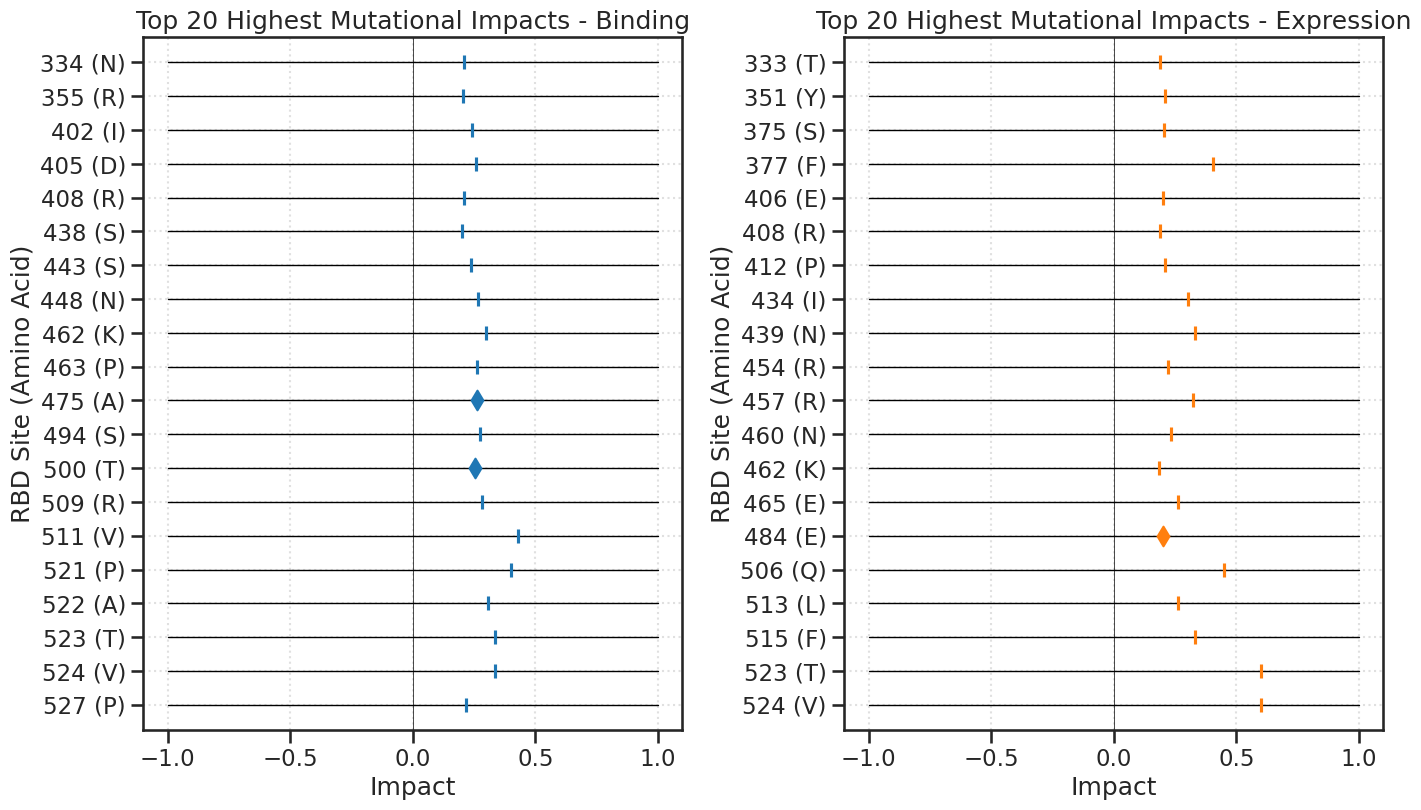

In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mutational_impact_limited(ax, impact_results_df, rbd_sites, BorE, interface_residues):
    df = impact_results_df[impact_results_df['RBD Site'].isin(rbd_sites)].copy()
    df = df.sort_values('RBD Site', ascending=False).reset_index(drop=True)

    sns.set_style("ticks")
    sns.set_context("talk")

    # Track y-tick positions and labels
    yticks = []
    ytick_labels = []

    for i, row in df.iterrows():
        rbd_site = row['RBD Site']
        aa = row['Original Amino Acid']
        impact = row['impact']

        # Background horizontal reference line
        ax.plot([-1, 1], [i, i], color='black', linewidth=1, zorder=1)

        # Main scatter plot
        ax.scatter(
            impact,
            i,
            color='tab:blue' if BorE == 'Binding' else 'tab:orange',
            marker='d' if rbd_site in interface_residues else '|',
            s=100,
            zorder=3
        )

        yticks.append(i)
        ytick_labels.append(f"{rbd_site} ({aa})")

    # Axes config
    ax.set_title(f'Top 20 Highest Mutational Impacts - {BorE}')
    ax.set_xlabel('Impact')
    ax.set_ylabel('RBD Site (Amino Acid)')
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.set_ylim(-0.75, len(yticks) - 0.25)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, linestyle=':', color='lightgrey', alpha=0.7)

fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharex=True)
fig.subplots_adjust(wspace=0.3)  # Reduce the horizontal space between subplots

# Binding sites
binding_rbd_sites = [
    334, 355, 402, 405, 408, 438, 443, 448, 462, 463, 475, 494, 500, 509, 511, 521, 522, 523, 524, 527
]
plot_mutational_impact_limited(axs[0], b_impact_results, binding_rbd_sites, "Binding", interface_residues)

# Expression sites
expression_rbd_sites = [
    333, 351, 375, 377, 406, 408, 412, 434, 439, 454, 457, 460, 462, 465, 484, 506, 513, 515, 523, 524
]
plot_mutational_impact_limited(axs[1], e_impact_results, expression_rbd_sites, "Expression", interface_residues)

plt.savefig("mutation/mutational_impact_limited.G.pdf", bbox_inches='tight')
plt.savefig("mutation/mutational_impact_limited.G.png", bbox_inches='tight')